In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from importlib.util import find_spec
if find_spec("qml_hep_lhc") is None:
    import sys
    sys.path.append('..')

In [10]:
from qml_hep_lhc.ansatzes import Farhi
import cirq
import numpy as np
import tensorflow_quantum as tfq
import tensorflow as tf
import matplotlib.pyplot as plt
from numba import njit, prange

In [11]:
def process_batch(circuits, symbol, op):
    """Compute the variance of a batch of expectations w.r.t. op on each circuit that 
    contains `symbol`. Note that this method sets up a new compute graph every time it is
    called so it isn't as performant as possible."""

    # Setup a simple layer to batch compute the expectation gradients.
    expectation = tfq.layers.Expectation()

    # Prep the inputs as tensors
    circuit_tensor = tfq.convert_to_tensor(circuits)
    values_tensor = tf.convert_to_tensor(
        np.random.uniform(0, 2 * np.pi, (n_circuits, 1)).astype(np.float32))

    # Use TensorFlow GradientTape to track gradients.
    with tf.GradientTape() as g:
        g.watch(values_tensor)
        forward = expectation(circuit_tensor,
                              operators=op,
                              symbol_names=[symbol],
                              symbol_values=values_tensor)

    # Return variance of gradients across all circuits.
    grads = g.gradient(forward, values_tensor)
    grad_var = tf.math.reduce_std(grads, axis=0)
    return grad_var.numpy()[0]

In [15]:
n_qubits = [2 * i for i in range(2, 10)]  # Ranges studied in paper are between 2 and 24.
depth = 2  # Ranges studied in paper are between 50 and 500.
n_circuits = 200
theta_var = []
ansatz = Farhi()

def resolve_circuits(circuits,symbols):
    for i in range(n_circuits):
        resolver = cirq.ParamResolver({s:np.random.uniform() * 2.0 * np.pi for s in symbols})
        circuits[i] = cirq.protocols.resolve_parameters(circuits[i], resolver)

for n in n_qubits:
    qc,_, symbols, op = ansatz.build(cirq.GridQubit.rect(1,n),None,depth, False)
    if not len(symbols) > 0:
        raise ValueError('No symbols found in circuit')
    symbol = symbols[0]
    symbols = symbols[1:]
    circuits = [qc]*n_circuits
    resolve_circuits(circuits,symbols)
    theta_var.append(process_batch(circuits,symbol,op))

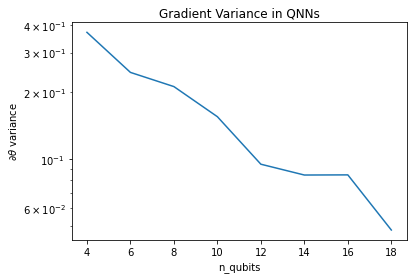

In [16]:
plt.semilogy(n_qubits, theta_var)
plt.title('Gradient Variance in QNNs')
plt.xlabel('n_qubits')
plt.xticks(n_qubits)
plt.ylabel('$\\partial \\theta$ variance')
plt.show()